# Word2Vec Embeddings - Using PySpark and PyArrow (distributed ML)

In [1]:
import numpy as np
import pandas as pd
import csv
import pickle
import time
import math
import collections
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
# !pip install pyspark
# !pip install -U -q PyDrive
# !sudo apt install openjdk-8-jdk-headless -qq
# !pip install pyarrow
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

initialise spark context

In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '35G')
        .set('spark.driver.memory', '35G')
        .set('spark.driver.maxResultSize', '35G'))
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# arrow enabling is what makes the conversion from pandas to spark dataframe really fast
sc._conf.get('spark.driver.memory')

'35G'

In [5]:
spark

# Step 1: No need to read in data if `CORPUS` is already saved (Skip to Step 2)

In [6]:
dirPath = '/home/ubuntu/Biomed-Data-Science-NLP-Project/Data/'
# patientData_filepath = dirPath + 'B220_SAA_v1.csv'
CCSR_filepath = dirPath + 'ICD_to_CCSR_20201_1.csv'

In [7]:
train = spark.read.load(dirPath + "train",
                     format="csv", sep=",", inferSchema="true", header="true")

In [8]:
train.columns

['ID',
 'Visit',
 'Visits',
 'Date',
 'Age',
 'Sex',
 'Race',
 'Dx10_prin',
 'Dx10_1',
 'Dx10_2',
 'Dx10_3',
 'Dx10_4',
 'Dx10_5',
 'Dx10_6',
 'Dx10_7',
 'Dx10_8',
 'Dx10_9',
 'Dx10_10',
 'Dx10_11',
 'Dx10_12',
 'Dx10_13',
 'Dx10_14',
 'Dx10_15',
 'Dx10_16',
 'Dx10_17',
 'Dx10_18',
 'Dx10_19',
 'Dx10_20',
 'Dx10_21',
 'Dx10_22',
 'Dx10_23',
 'Dx10_24',
 'label']

In [9]:
def read_csv_to_dict(file_path: str, key: int, value: int):
    ret_dict = {}
    with open(file_path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter=',')
        for row in data:
            ret_dict[row[key][1:-1]] = row[value][1:-1] # "'icd_code'"
    print("Reading {} complete!".format(file_path))
    return ret_dict

In [10]:
icd_to_ccsr_code = read_csv_to_dict(CCSR_filepath, key=0, value=6) # 'icd_code' -> 'CCSR_code'
ccsr_codes = list(np.unique(list(icd_to_ccsr_code.values())))
ccsr_codes.remove('CCSR CATEGORY 1')

ccsr_code_to_index = collections.defaultdict(int)
for i, ccsr_code in enumerate(ccsr_codes):
    ccsr_code_to_index[ccsr_code] = i
    
print("{} CCSR categories".format(len(ccsr_code_to_index.keys())))

Reading /home/ubuntu/Biomed-Data-Science-NLP-Project/Data/ICD_to_CCSR_20201_1.csv complete!
519 CCSR categories


In [11]:
s1 = time.time()
icd_codes_table = train.select(train.columns[7:32])
s2 = time.time()
print("Read data in {} minutes".format((s2-s1)/60))

Read data in 0.0017907182375590006 minutes


In [12]:
# icd_codes_table.show()

In [13]:
icd_codes_table = icd_codes_table.toPandas()

In [14]:
corpus = [[elem for elem in row if type(elem) == str] for row in icd_codes_table.values.tolist()]
# corpus = [[icd1, icd2, icd3], [icd1, icd2],...]
s3 = time.time()
print("Corpus complete in {} minutes".format((s3-s1)/60))

Corpus complete in 4.029713698228201 minutes


In [15]:
len(corpus)

18766186

In [16]:
def sentenceToCCSR(sentence):
    '''
    Need the dict for 2 reasons:
    1. Keep only visits that have a single visit
    2. To count the frequency of each of the CCSR codes overall for patients w/ > 1 visit 
    '''
    ccsrSentence = ""
    ccsr_codes = defaultdict(int)
    for i, ICD_code in enumerate(sentence):
        if i==0:
            try:
                ccsr_code = str(icd_to_ccsr_code[ICD_code])
                ccsrSentence += ccsr_code
                ccsr_codes[ccsr_code]+=1
            except:
                pass
        else:
            try:
                ccsr_code = str(icd_to_ccsr_code[ICD_code])
                ccsrSentence += " " + ccsr_code
                ccsr_codes[ccsr_code]+=1
            except:
                pass
    return ccsrSentence, ccsr_codes

In [17]:
# Cycle through each sentence in corpus and generate stringed CCSR sentences
stringed_sentences = []
unique_ccsr_codes = Counter()
for s, inSentence in tqdm(enumerate(corpus)):
    sentence, codes_set = sentenceToCCSR(inSentence) # ICD -> CCSR
    if len(codes_set)>1:
        unique_ccsr_codes = unique_ccsr_codes + Counter(codes_set)
#     if sentence is not "":
        stringed_sentences.append(sentence)

18766186it [1:02:49, 4978.37it/s]


In [19]:
print("Number of unique codes in the training data are: {}".format(len(unique_ccsr_codes)))

Number of unique codes in the training data are: 502


In [ ]:
labels, vals = zip(*unique_ccsr_codes.items())

indexes = np.arange(len(labels))
width = 1

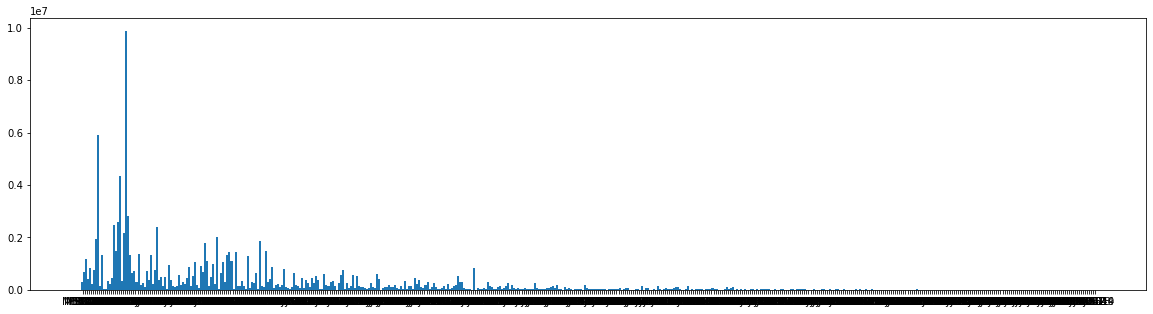

In [23]:
plt.figure(figsize = (20,5))
plt.bar(indexes, vals, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [24]:
filename = dirPath + "train_stringed_CCSR_sentences.pkl"

uncomment this to save the file

In [26]:
# with open(filename, 'wb') as handle:
#     pickle.dump(stringed_sentences, handle)

# Step 2: Load the `CORPUS` of CCSR codes in patient visits

In [27]:
with open(filename, 'rb') as handle:
    stringed_sentences = pickle.load(handle)

In [32]:
# corpus = icd_to_ccsr_code = icd_codes_table = ccsr_code_to_index  = ccsr_codes = None

## Create PySpark DataFrame from Pandas

In [33]:
tic = time.time()
df = pd.DataFrame(stringed_sentences, columns = ['sentences'])
toc = time.time()
print("time taken : {}s".format(toc - tic))
del stringed_sentences

# convert to Spark DF
sparkDF=spark.createDataFrame(df) 
print("time taken : {}s".format(time.time() - toc))
sparkDF.printSchema()
sparkDF.show()

time taken : 1.3801155090332031s
time taken : 9.156926393508911s
root
 |-- sentences: string (nullable = true)

+--------------------+
|           sentences|
+--------------------+
|MBD012 MBD001 MBD002|
|PRG028 SYM004 SYM...|
|SYM006 FAC021 FAC021|
|CIR009 CIR019 CIR...|
|RSP008 SYM010 CIR...|
|       GEN017 GEN017|
|       MUS025 MUS010|
|              MBD005|
|              CIR012|
|INJ011 INJ027 MUS...|
|       SYM011 CIR007|
|              FAC025|
|GEN004 CIR007 FAC021|
|DIG021 GEN002 END...|
|FAC001 INJ017 INJ...|
|MUS026 INJ030 GEN...|
|              INJ017|
|       DIG002 FAC025|
|INJ003 CIR012 FAC021|
|              RSP003|
+--------------------+
only showing top 20 rows



Cannot save spark dataframes as it is gives a ` can't pickle _thread.RLock objects` Typeerror. Because of parallelized implementation

## Tokenize the stringed CCSR sentences

In [34]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import Word2Vec, Word2VecModel
from pyspark.ml import Pipeline

embed_size=100
tokenizer = Tokenizer(inputCol="sentences", outputCol="tokens")
tic = time.time()
tokenized = tokenizer.transform(sparkDF).select("tokens")
print("time taken : {}s".format(time.time() - tic))

time taken : 0.20386981964111328s


Cannot save spark dataframes as it is gives a ` can't pickle _thread.RLock objects` Typeerror. Because of parallelized implementation

In [35]:
tokenized.show(3)
tokenized.count()

+--------------------+
|              tokens|
+--------------------+
|[mbd012, mbd001, ...|
|[prg028, sym004, ...|
|[sym006, fac021, ...|
+--------------------+
only showing top 3 rows



18766186

## Look at the distribution of *number of CCSR codes in a sentence*
7 being the num chars occupied by a single CCSR code+space character

In [36]:
word_count = sparkDF.rdd.map(lambda x: (x, len(x.sentences)/7)) # 

In [37]:
wc = word_count.toDF(["sentence", "length"])

In [ ]:
# unique_words = wc.select(explode(split(col("sentence"),",")).alias("ccsr_code")).distinct()
# above line to count number of unique codes -- not needed though (did counting already) 
# -- takes super duper long

In [ ]:
# wc.show(20, truncate = False) # takes super duper long

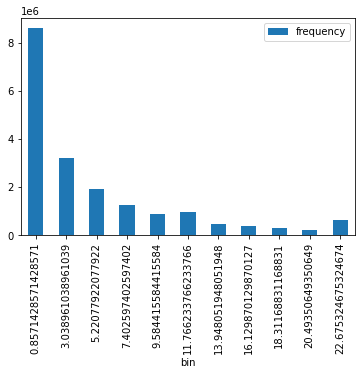

In [38]:
# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api
wc_histogram = wc.select('length').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*wc_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

# Step 3: Train word2vec

In [24]:
w2v = Word2Vec(vectorSize=embed_size, minCount=1, inputCol="tokens", outputCol="features")\
            .setSeed(1234).setWindowSize(1)
tic = time.time()
word2vec_model = w2v.fit(tokenized)
print("time taken : {}mins".format((time.time() - tic)/60))

time taken : 1816.4596192836761


default parameter for `window size` is 5. `minCount` is the minimum number of times a token must appear to be included in the word2vec model's vocabulary

In [26]:
word2vec_model

Word2VecModel: uid=Word2Vec_d0fae05febe4, numWords=502, vectorSize=100

In [ ]:
tic  =time.time()
path  = dirPath + "pyspark_w2v_embeddingSize_{}".format(embed_size)
if os.path.exists(path):
    os.remove(path)
word2vec_model.save(path)
print("time taken : {}".format(time.time() - tic))

In [33]:
tic  =time.time()
loaded_model = Word2VecModel.load(path)
print("time taken : {}s".format(time.time() - tic))

time taken : 0.9137392044067383


### Load the model to get the word2vec vectors for every ccsr code

In [38]:
tic = time.time()
word2vec_df = loaded_model.getVectors()
print("time taken : {}".format(time.time() - tic))
word2vec_df.show(3)
word2vec_df

time taken : 0.019066810607910156
+------+--------------------+
|  word|              vector|
+------+--------------------+
|inj029|[-0.2791734635829...|
|skn005|[0.13488520681858...|
|inj033|[-0.1691723316907...|
+------+--------------------+
only showing top 3 rows



DataFrame[word: string, vector: vector]

# Step 4 Testing: transform vectors of choice using the trained data

In [36]:
test_df = pd.DataFrame(["prg028 prv028 prv028", "prv028"], columns = ['sentences'])
testing_sparkDF =spark.createDataFrame(test_df)
testing_sparkDF = tokenizer.transform(testing_sparkDF).select("tokens")
testing_sparkDF.show(2)

+--------------------+
|              tokens|
+--------------------+
|[prg028, prv028, ...|
|            [prv028]|
+--------------------+



In [37]:
tic  =time.time()
res = loaded_model.transform(testing_sparkDF)
print("time taken : {}s".format(time.time() - tic))
res.show(3)

time taken : 0.05219721794128418
+--------------------+--------------------+
|              tokens|            features|
+--------------------+--------------------+
|[prg028, prv028, ...|[0.09811954696973...|
|            [prv028]|[0.0,0.0,0.0,0.0,...|
+--------------------+--------------------+



In [ ]:
# res.toPandas().head().loc[:,"features"][0]